### LLM FROM SCRATCH

##### _WORKFLOW_
1. Get tokenizer
2. Create dataloader class for data handling
3. Create classes for MHA, Layer Norm & Feed Forward Network
4. Create class for the Transformer Block and add classes from point number 3
5. Create class for the SLM and add transformer class
6. Define function for text generation, encoding & decoding
7. Load the dataset
8. Create the tarin and test loader duing the dataloader class from point number 2
9. Create functions to calculate & record the loss during training
10. Create function for model training & train the model
11. Implement decoding startegies

---

Import libraries.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tiktoken
import time

Get the tokenizer.

In [2]:
tokenizer = tiktoken.get_encoding('gpt2')

Class to create the dataset for our model.

In [3]:
class DatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_len, stride): # max_len is context size
        self.input_ids = []
        self.target_ids = []

        # tokenize the text
        token_ids = tokenizer.encode(txt, allowed_special = {"<|endoftext|>"})

        # sliding window to create overlapping sequences
        for i in range(0, len(token_ids) - max_len, stride):
            input_chunk = token_ids[i:i + max_len]
            target_chunk = token_ids[i + 1:i + max_len + 1]
            self.input_ids.append(input_chunk)
            self.target_ids.append(target_chunk)
    
    # the below 2 methods is required for Dataloader to be used
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx): # we are basically saying that if the input is the 50th tensor, then the output is the 50th tensor
        return (
            torch.tensor(self.input_ids[idx], dtype=torch.long),
            torch.tensor(self.target_ids[idx], dtype=torch.long)
        )

Helper function to create dataloaders.

In [4]:
def create_dataloader_v1(txt, batch_size = 4, max_len = 256, stride = 128, shuffle = True, drop_last = True, num_workers = 0):
    # drop last if last tensor is shorter than max_len
    # batch size is the number of training ip-op data pairs to be used for training by whcih the parameters are updated
    tokenizer = tiktoken.get_encoding('gpt2')
    dataset = DatasetV1(txt, tokenizer, max_len, stride)
    dataloader = DataLoader(
        dataset, 
        batch_size = batch_size,
        shuffle = shuffle,
        drop_last = drop_last,
        num_workers = num_workers
    )
    return dataloader

The MHA class.

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_len, dropout, num_heads, qkv_bias = False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        # s2
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        # s3
        self.W_q = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # to combine head outputs
        self.dropout = nn.Dropout(dropout) 
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_len, context_len), diagonal = 1)
        )

    def forward(self, x):
        b, num_tokens, d_out = x.shape # s1

        # s4
        keys = self.W_k(x)
        queries = self.W_q(x)
        values = self.W_v(x)
        
        # s5
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # s6
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # s7
        attention_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attention_scores.masked_fill_(mask_bool, -torch.inf)
        attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)
        attention_weights = self.dropout(attention_weights) # s8

        context_vec = (attention_weights @ values).transpose(1, 2) # s9 & s10
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # s11
        context_vec = self.out_proj(context_vec) # optional
 
        return context_vec

Classes for layer norm, GELU activation function & feed forwards network.

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True, unbiased = False) # unbiased so var is divided by n-1
        norm = (x - mean) / (torch.sqrt(var + self.eps)) # epsilon to prevent division by 0
        return self.scale * norm + self.shift # element wise operations - trainable parameters to learn appropriate scaling and shifting of norm values that best suits the data
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))
    
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # expansion
            GELU(), # activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), # contraction
        )
    
    def forward(self, x):
        return self.layers(x)

The transformer block.

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention( # converts input to context vectors  
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_len = cfg["context_len"],
            num_heads = cfg["num_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        # MHA
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # shape: [batch size, num tokens, emb size]
        x = self.drop_shortcut(x)
        x = x + shortcut # f(x) + x

        # FCL
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # f(x) + x

        return x

The SLM class.

In [8]:
class SLM(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )
        
    def forward(self, in_idx): # input batch
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

Helper function when generating text during each epoch of training.

In [9]:
def generate_text_simple(model, idx, max_new_tokens, context_size): # idx is the input batch
    for _ in range(max_new_tokens):
        # crop current context
        idx_cond = idx[:, -context_size:]
        # get predictions
        with torch.no_grad():
            logits = model(idx_cond) # batch_size x tokens_num x vocab_size
        # get the last time step (last set of logits)
        logits = logits[:, -1, :]
        # apply softmax
        probs = torch.softmax(logits, dim = -1)
        # get id of max
        idx_next = torch.argmax(probs, dim = -1, keepdim = True)
        # append id to running sequence
        idx = torch.cat((idx, idx_next), dim = -1)
    return idx

Configure model settings.

In [10]:
SLM_CONFIG = {
    "vocab_size" : 50257,
    "context_len" : 512,
    "emb_dim" : 768,
    "num_heads" : 8, # attention heads
    "n_layers" : 8, # transformer blocks
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

Define model.

In [11]:
model = SLM(SLM_CONFIG)

Function for encoding & decoding.

In [12]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

Load Openweb text data.

In [13]:
data = np.memmap("train.bin", dtype = np.uint16, mode = "r")
print("Number of tokens for whole dataset:", f"{len(data):,}")
enc = tiktoken.get_encoding("gpt2")

Number of tokens for whole dataset: 3,378,008,151


In [14]:
small = int(len(data) / 200)
print("Number of tokens for small dataset:", f"{len(data[:small]):,}")

Number of tokens for small dataset: 16,890,040


In [15]:
start = time.time()
raw_text = enc.decode(data[:small])
end = time.time()

In [16]:
print(f"Time taken to load the text data: {(end - start) / 60:.3f} minutes")
print(f"Sample text: {raw_text[:110]}")

Time taken to load the text data: 0.084 minutes
Sample text: Freedom and democracy are said to be guarantees of human rights, but as the NSA spying scandal recently showed


Adding personal data.

In [17]:
with open("me.txt", "r", encoding = "utf-8") as t:
    personal_text = t.read()

raw_text += personal_text

Create data loader (a.k.a, PyTorch way of making train-test-splits).

In [18]:
train_ratio = 0.9
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
test_data = raw_text[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_len = SLM_CONFIG["context_len"],
    stride = SLM_CONFIG["context_len"],
    drop_last = True,
    shuffle = True,
    num_workers = 0
)

test_loader = create_dataloader_v1(
    test_data,
    batch_size = 2,
    max_len = SLM_CONFIG["context_len"],
    stride = SLM_CONFIG["context_len"],
    drop_last = False,
    shuffle = False,
    num_workers = 0
)

In [19]:
len(train_loader)

14875

Functions to calculate loss.

In [40]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten()) # this does all the softmax & everything
    return loss

def calc_loss_loader(data_loader, model, device, num_batches = None): # this will show the loss of the LM
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batches # mean loss per batch

Function to record loss.

In [41]:
# model evaluation function
def evaluate_model(model, train_loader, test_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches = eval_iter)
        test_loss = calc_loss_loader(test_loader, model, device, num_batches = eval_iter)
    model.train()
    return train_loss, test_loss

Function to generate text after each epoch during training.

In [42]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model = model, idx = encoded, max_new_tokens = 50, context_size = context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    print()
    model.train() # set it back to training mode

Function to train the model.

In [ ]:
def train_model_simple(model, train_loader, test_loader, optimizer, device, 
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    
    train_losses, test_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train() # set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # reset gradients from previous batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel() # return number of tokens seen
            global_step += 1

            # evaluation (optional)
            if global_step % eval_freq == 0: # only after a set of batches is used for training
                train_loss, test_loss = evaluate_model(
                    model, train_loader, test_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                test_losses.append(test_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch + 1} (Step {global_step:04d}): "
                      f"Train loss {train_loss:.3f}, Test loss {test_loss:.3f}")
            
        # print sample text from each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
        
    return train_losses, test_losses, track_tokens_seen

Train the model.

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model.to(device)

Device: cuda


SLM(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(512, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=

In [45]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters to train: {total_params:,}")

Total number of parameters to train: 134,274,048


In [46]:
import time
start = time.time()

torch.manual_seed(123)
model = SLM(SLM_CONFIG)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay = 0.1)

num_epochs = 5
train_losses, test_losses, tokens_seen = train_model_simple(
    model, train_loader, test_loader, optimizer, device, 
    num_epochs = num_epochs, eval_freq = 500, eval_iter = 500, # after every 500 batches, training and validation loss will be printed
    start_context = "What are human rights?", tokenizer = tokenizer
) 

end = time.time()
training_time = (end - start) / 60
print(f"Training completed in {training_time:.2f} minutes.")

Epoch 1 (Step 0000): Train loss 10.252, Test loss 10.256
Epoch 1 (Step 0500): Train loss 6.927, Test loss 6.985
Epoch 1 (Step 1000): Train loss 6.755, Test loss 6.827
Epoch 1 (Step 1500): Train loss 6.528, Test loss 6.625
Epoch 1 (Step 2000): Train loss 6.458, Test loss 6.542
Epoch 1 (Step 2500): Train loss 6.358, Test loss 6.486
Epoch 1 (Step 3000): Train loss 6.308, Test loss 6.409
Epoch 1 (Step 3500): Train loss 6.275, Test loss 6.379
Epoch 1 (Step 4000): Train loss 6.202, Test loss 6.334
Epoch 1 (Step 4500): Train loss 6.172, Test loss 6.303
Epoch 1 (Step 5000): Train loss 6.132, Test loss 6.276
Epoch 1 (Step 5500): Train loss 6.072, Test loss 6.251
Epoch 1 (Step 6000): Train loss 6.027, Test loss 6.204
Epoch 1 (Step 6500): Train loss 6.035, Test loss 6.207
Epoch 1 (Step 7000): Train loss 6.030, Test loss 6.181
Epoch 1 (Step 7500): Train loss 6.000, Test loss 6.183
Epoch 1 (Step 8000): Train loss 5.971, Test loss 6.139
Epoch 1 (Step 8500): Train loss 5.968, Test loss 6.130
Epoch 1 

Visualizing the loss plot.

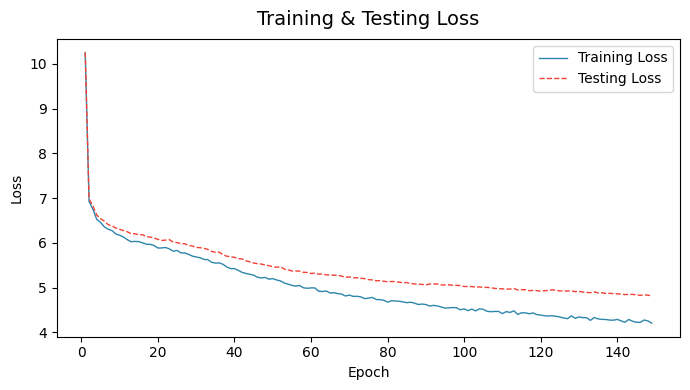

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize = (7, 4))

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label = 'Training Loss', color = '#2E86AB', linewidth = 1)
plt.plot(epochs, test_losses, label = 'Testing Loss', color = '#F24236', linewidth = 1, linestyle='--')

plt.title("Training & Testing Loss", fontsize = 14, pad = 10)
plt.xlabel("Epoch", fontsize = 10)
plt.ylabel("Loss", fontsize = 10)

plt.legend(frameon = True, fancybox = True)

plt.tight_layout()
plt.show()

Function to implement decoding strategies.

In [48]:
def generate(model, idx, max_new_tokens, context_size, temperature = 0.0, top_k = None, eos_id = None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val, 
                torch.tensor(float("-inf")).to(logits.device),
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim = -1)
            idx_next = torch.multinomial(probs, num_samples = 1)

        else:
            idx_next = torch.argmax(logits, dim = -1, keepdim = True)
        
        if idx_next == eos_id:
            break
            
        idx = torch.cat((idx, idx_next), dim = 1)
    
    return idx

Text generation after applying decoding strategies.

In [58]:
# torch.manual_seed(123)

token_ids = generate(
    model = model, 
    idx = text_to_token_ids("I used to think", tokenizer).to(device),
    max_new_tokens = 65,
    context_size = SLM_CONFIG["context_len"],
    top_k = 25,
    temperature = 1.4
)

print("Output:", token_ids_to_text(token_ids, tokenizer))

Output: I used to think about this kind of stuff. It was a lot of stuff because it was bad. I knew he’d like the show about a bit too much than he did about to get it because he wanted to see the show that it had a good show. This time we would see the film was just something I can find
